In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from langdetect import detect_langs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('ratebeer.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,name,id,brewerID,abv,style,appearance,aroma,palate,taste,overall,time,profileName,reviewtext
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Mar,10-Jun,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Apr,10-Jul,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,5-Apr,10-May,5-Mar,10-Jun,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
df_1 = df.sample(frac=0.25)
df_1.shape

(262144, 13)

In [5]:
df_2 = df.sample(frac=0.05)
df_2.shape

(52429, 13)

In [6]:
df_3 = df_2[['name', 'reviewtext']]
df_3.head()

,name,reviewtext
743689,Mac and Jacks African Amber Ale,From a growler. Fruity aroma. Taste is fruity ...
178468,Tyranena BGW Hop Whore Imperial India Pale Ale,"Golden, thin head. Soft aroma, hops, honey, fl..."
256816,Stone 15th Anniversary Escondidian Imperial Bl...,"I Love it man. Need a walk in the woods, drin..."
439353,Alhambra Negra,In the bottle at Espana tapas bar in Benson. P...
485245,Ballast Point Tongue Monster,Served on tap at the Linda Vista location duri...


In [7]:
df_3 = df_3.rename(columns={'reviewtext': 'review'})

# length of the reviews
length_reviews = df_3.review.str.len()
df_3['length'] = length_reviews
df_3.head()

,name,review,length
743689,Mac and Jacks African Amber Ale,From a growler. Fruity aroma. Taste is fruity ...,112.0
178468,Tyranena BGW Hop Whore Imperial India Pale Ale,"Golden, thin head. Soft aroma, hops, honey, fl...",152.0
256816,Stone 15th Anniversary Escondidian Imperial Bl...,"I Love it man. Need a walk in the woods, drin...",494.0
439353,Alhambra Negra,In the bottle at Espana tapas bar in Benson. P...,373.0
485245,Ballast Point Tongue Monster,Served on tap at the Linda Vista location duri...,397.0


In [8]:
avg_length = df_3.length.mean()
print('Average Length: {}'.format(avg_length))

Average Length: 308.6346253032532


In [9]:
longest_review = df_3['length'].max()
shortest_review = df_3['length'].min()
print('Longest Review: {}'.format(longest_review))
print('Shortest Review: {}'.format(shortest_review))

Longest Review: 4009.0
Shortest Review: 4.0


In [10]:
df_4 = df_3.sort_values(by=['length'], ascending=False)
df_4.head()

,name,review,length
251494,Stone Bourbon Barrel Russian Imperial Stout,May 2008 Release; Sampled June 2008\tA careful...,4009.0
240479,Stone Old Guardian &#40;Vintages through 2003&...,"UPDATED: OCT 12, 2008 Name: Old Guardian\tDate...",3854.0
325890,Coronado Hoppy Daze IPA,A solid pour into my 25cl tulip glass produces...,3241.0
265101,Stone Old Guardian &#40;Vintages 2004 and late...,"UPDATED: NOV 1, 2007 Early 2007 Release\tAfter...",3232.0
922901,BFM Cuvée du 8ème,"UPDATED: JUN 15, 2010 Sampled on tap April 201...",3005.0


In [11]:
reviews = df_4.sample(frac=0.50)
reviews.head()

,name,review,length
523055,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0
965308,Berg Radler,"bottle. Clear pale yellow, medium-sized head. ...",122.0
489356,Bischoff Falkensteiner Ur-Weisse,Bischoff Ur-weisse pours a thick cloudy orange...,1172.0
449981,Rock Bottom Portland Maude Flanders,Had this on tap at the 2nd anniv. of Baileys T...,401.0
714903,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 523055 to 414116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    26214 non-null  object 
 1   review  26168 non-null  object 
 2   length  26168 non-null  float64
dtypes: float64(1), object(2)
memory usage: 819.2+ KB


In [13]:
review = str(reviews.review)

In [14]:
languages = []

for r in range(len(reviews)):
    languages.append(detect_langs(reviews.iloc[r, 0]))

In [15]:
languages = [str(lang).split(':')[0][1] for lang in languages]

In [16]:
reviews['lang'] = languages
reviews.head()

,name,review,length,lang
523055,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0,e
965308,Berg Radler,"bottle. Clear pale yellow, medium-sized head. ...",122.0,d
489356,Bischoff Falkensteiner Ur-Weisse,Bischoff Ur-weisse pours a thick cloudy orange...,1172.0,d
449981,Rock Bottom Portland Maude Flanders,Had this on tap at the 2nd anniv. of Baileys T...,401.0,s
714903,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0,e


In [17]:
# Removing non english reviews and Keeping only reviews in english

reviews_e = reviews.loc[lambda reviews: reviews['lang'] == 'e']
reviews_e

,name,review,length,lang
523055,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0,e
714903,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0,e
735106,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",489.0,e
662784,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,784.0,e
411213,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",317.0,e
...,...,...,...,...
801342,Blue Moon Harvest Moon Pumpkin Ale,"Small tan head, short lived. Clear amber color...",230.0,e
1018091,North Coast Old Rasputin Russian Imperial Stout,"On tap at Flying Saucer... pours dard brown, t...",166.0,e
351012,Sports City Cafe Warrior Pale Ale,This was definitely the type of unique pale al...,615.0,e
877115,Thirsty Dog Hoppus Maximus,Orange/amber pour with an inviting citrus hop ...,149.0,e


In [18]:
avg_length_e = reviews_e.length.mean()
longest_review_e = reviews_e['length'].max()
shortest_review_e = reviews_e['length'].min()
print('Average Length: {}'.format(avg_length_e))
print('Longest Review: {}'.format(longest_review_e))
print('Shortest Review: {}'.format(shortest_review_e))

Average Length: 320.1277356288299
Longest Review: 4009.0
Shortest Review: 4.0


In [19]:
reviews_e['review'] = reviews_e['review'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
reviews_e['sentiment'] = round(reviews_e['review'].apply(lambda x: TextBlob(x).sentiment[0]),2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
reviews_e

,name,review,length,lang,sentiment
523055,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0,e,0.11
714903,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0,e,0.28
735106,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",489.0,e,0.15
662784,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,784.0,e,-0.01
411213,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",317.0,e,0.11
...,...,...,...,...,...
801342,Blue Moon Harvest Moon Pumpkin Ale,"Small tan head, short lived. Clear amber color...",230.0,e,0.21
1018091,North Coast Old Rasputin Russian Imperial Stout,"On tap at Flying Saucer... pours dard brown, t...",166.0,e,0.30
351012,Sports City Cafe Warrior Pale Ale,This was definitely the type of unique pale al...,615.0,e,0.19
877115,Thirsty Dog Hoppus Maximus,Orange/amber pour with an inviting citrus hop ...,149.0,e,0.44


In [22]:
reviews_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13726 entries, 523055 to 414116
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       13726 non-null  object 
 1   review     13726 non-null  object 
 2   length     13708 non-null  float64
 3   lang       13726 non-null  object 
 4   sentiment  13726 non-null  float64
dtypes: float64(2), object(3)
memory usage: 643.4+ KB


In [23]:
reviews_1 = reviews_e

In [24]:
reviews_1.reset_index(drop=True, inplace=True)

In [25]:
reviews_1.head()

,name,review,length,lang,sentiment
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0,e,0.11
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0,e,0.28
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",489.0,e,0.15
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,784.0,e,-0.01
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",317.0,e,0.11


In [26]:
sentiment_1 = []

for i in range(len(reviews_1)):
    if reviews_1.sentiment[i] >= 0.10:
        sentiment_1.append(2)
    elif reviews_1.sentiment[i] >= -0.10:
        sentiment_1.append(0)
    else:
        sentiment_1.append(1)

In [27]:
reviews_1['sentiment_1'] = sentiment_1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
reviews_1

,name,review,length,lang,sentiment,sentiment_1
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,603.0,e,0.11,2
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",180.0,e,0.28,2
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",489.0,e,0.15,2
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,784.0,e,-0.01,0
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",317.0,e,0.11,2
...,...,...,...,...,...,...
13721,Blue Moon Harvest Moon Pumpkin Ale,"Small tan head, short lived. Clear amber color...",230.0,e,0.21,2
13722,North Coast Old Rasputin Russian Imperial Stout,"On tap at Flying Saucer... pours dard brown, t...",166.0,e,0.30,2
13723,Sports City Cafe Warrior Pale Ale,This was definitely the type of unique pale al...,615.0,e,0.19,2
13724,Thirsty Dog Hoppus Maximus,Orange/amber pour with an inviting citrus hop ...,149.0,e,0.44,2


In [29]:
reviews_1['sentiment_1'].value_counts()

2    9016
0    4034
1     676
Name: sentiment_1, dtype: int64

In [30]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13726 entries, 0 to 13725
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         13726 non-null  object 
 1   review       13726 non-null  object 
 2   length       13708 non-null  float64
 3   lang         13726 non-null  object 
 4   sentiment    13726 non-null  float64
 5   sentiment_1  13726 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 643.5+ KB


In [31]:
positive = []
negative = []
neutral = []

for i in range(len(reviews_1.sentiment_1)-1):
    if reviews_1.sentiment_1[i] == 2:
        positive.append(reviews_1.review[i])
    elif reviews_1.sentiment_1[i] == 1:
        negative.append(reviews_1.review[i])
    else:
        neutral.append(reviews_1.review[i])
   

In [32]:
len(review)

702

In [33]:
print(len(positive))
print(len(negative))
print(len(neutral))

9015
676
4034


In [34]:
positive_string = str(positive)
negative_string = str(negative)
neutral_string = str(neutral)

In [40]:
# my_stop_words = ENGLISH_STOP_WORDS.union(['Aroma', 'head', 'is'])
stop_words = ['Aroma', 'head', 'is']+list(STOPWORDS)

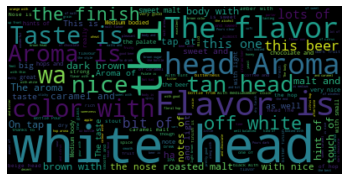

In [41]:
positive_cloud = WordCloud(stopwords = stop_words).generate(positive_string)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

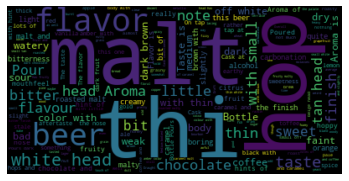

In [42]:
negative_cloud = WordCloud(stopwords = stop_words).generate(negative_string)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

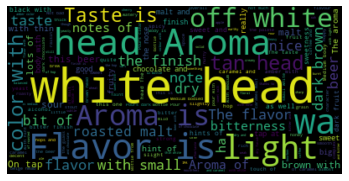

In [43]:
neutral_cloud = WordCloud(stopwords = stop_words).generate(neutral_string)
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
reviews_2 = reviews_1.drop(['length', 'lang', 'sentiment'], axis=1)
reviews_2.head()

,name,review,sentiment_1
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,2
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",2
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",2
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,0
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",2


In [45]:
reviews_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13726 entries, 0 to 13725
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         13726 non-null  object
 1   review       13726 non-null  object
 2   sentiment_1  13726 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 321.8+ KB


In [46]:
X = reviews_2.drop('sentiment_1', axis=1)
X.head()

,name,review
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re..."
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de..."
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of..."


In [47]:
y = reviews_2['sentiment_1']
y.head()

0    2
1    2
2    2
3    0
4    2
Name: sentiment_1, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
X_train.head()

,name,review
2531,Floris Mango,A Mes rate: \tBottle from I dont care where. M...
441,Highland Cattail Peak Wheat,"12oz bottle, courtesy of TURDFERGUSON, thanks ..."
5799,John Harvards Pumpkin Spice Ale,Poured a lightly hazed chestnut color with an...
12612,City Light,This beer is just like a bud or busch light. I...
11390,High & Mighty St. Hubbins Abbey Ale,"HogTownHarrys bottle, shared with Blankboy and..."


In [50]:
X_test.head()

,name,review
11615,La Rulles Jean Chris Numero 1,On tap at Ma Che Siete Venuti a Fa. Hazy golde...
13720,Shipyard Export Ale,"Bottle. Aroma is strongly of hops, with a slig..."
8415,Newby Wyke Bear Island,Gravity cask at Maidstone BF. Slightly hazy go...
5688,Allagash Dubbel Reserve,"Deep muddy red-brown. Nose quite sweet, candy..."
6187,Shipyard Export Ale,I just did not pick up anything other than a d...


In [51]:
X_test = X_test.reset_index().drop('index', axis=1)
X_test

,name,review
0,La Rulles Jean Chris Numero 1,On tap at Ma Che Siete Venuti a Fa. Hazy golde...
1,Shipyard Export Ale,"Bottle. Aroma is strongly of hops, with a slig..."
2,Newby Wyke Bear Island,Gravity cask at Maidstone BF. Slightly hazy go...
3,Allagash Dubbel Reserve,"Deep muddy red-brown. Nose quite sweet, candy..."
4,Shipyard Export Ale,I just did not pick up anything other than a d...
...,...,...
2741,Rugby Victorious,Cask at Guillford ... amber ... thin white hea...
2742,Lucky Labrador Super Dog,Draft @ the brewpub. Pours a hazy orange color...
2743,Mishawaka Transit of Venus Sunrise Ale,On tap at the brewery. This was really a toast...
2744,AleSmith Horny Devil,Crushed at GABF 10. Was excited to taste this...


In [52]:
count_vect = CountVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')
count_vect.fit(X_train.review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [53]:
X_train_transformed = count_vect.transform(X_train.review)
train_df = pd.DataFrame(X_train_transformed.toarray(), columns=count_vect.get_feature_names())
train_df.head()

,01,02,03,04,05,06,06 bottle,07,08,08 pours,...,youngs,youre,youve,yuck,yum,yummy,zero,zest,zesty,zing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
print(type(train_df))
print(train_df.shape)
# print(review_text_count.toarray())
##print(count_vect.get_feature_names())
##print(reviews_1.review)

<class 'pandas.core.frame.DataFrame'>
(10980, 10000)


In [55]:
tfidf_trans = TfidfTransformer().fit(train_df)

In [56]:
training_tfidf = tfidf_trans.transform(train_df)
print(type(training_tfidf))
##print(training_tfidf)




<class 'scipy.sparse.csr.csr_matrix'>


In [57]:
tfidf_df = pd.DataFrame(training_tfidf.toarray())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199575,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [58]:
test_countvect = count_vect.transform(X_test.review)
test_tfidf = tfidf_trans.transform(test_countvect)
print(type(test_tfidf))
print(pd.DataFrame(test_tfidf.toarray()).shape)

<class 'scipy.sparse.csr.csr_matrix'>
(2746, 10000)


In [59]:
lr = LogisticRegression()
lr.fit(tfidf_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_pred = lr.predict(test_tfidf)

In [63]:
proba = lr.predict_proba(test_tfidf)

In [113]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test, y_pred)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, proba[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test, y_pred)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test, y_pred)))

Accuracy Score: 0.7825928623452294

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       807
           1       1.00      0.02      0.04       135
           2       0.81      0.94      0.87      1804

    accuracy                           0.78      2746
   macro avg       0.83      0.51      0.51      2746
weighted avg       0.78      0.78      0.76      2746


Confusion Matrix:
[[ 451    0  356]
 [ 102    3   30]
 [ 109    0 1695]]



In [64]:
pred_df = pd.DataFrame(X_test['name'], y_pred)
pred_df

,name
2,Newby Wyke Bear Island
2,Newby Wyke Bear Island
0,La Rulles Jean Chris Numero 1
2,Newby Wyke Bear Island
2,Newby Wyke Bear Island
...,...
0,La Rulles Jean Chris Numero 1
0,La Rulles Jean Chris Numero 1
2,Newby Wyke Bear Island
2,Newby Wyke Bear Island


In [65]:
pred_df.to_csv('prediction.csv')

In [146]:
test = pd.read_csv('reviews.csv')
test

,review
0,Fruity aroma on the nose which made me think i...
1,I don't typically like stouts but decided to t...
2,Pils are my favorite beer so I'm sorry to say ...
3,Pours very dark brown with a small short-lasti...
4,Peach juice colour. Bubbly head. Aroma is rasp...
5,Hazy golden colour. Aroma is grassy with some ...
6,"Very clear, pale amber nearing lemon. Only sma..."
7,The beer is a hazy copper-red color with a med...
8,I'm not much of a stout guy buy enjoyed the 20...
9,Interesting pour to this as it had a blueberry...


In [148]:
test_reviews_countvect = count_vect.transform(test.review)
test_reviews_tfidf = tfidf_trans.transform(test_reviews_countvect)
print(type(test_reviews_tfidf))
print(pd.DataFrame(test_reviews_tfidf.toarray()).shape)

<class 'scipy.sparse.csr.csr_matrix'>
(21, 10000)


In [ ]:
test_reviews_df = pd.DataFrame()
print(pd.DataFrame(test_reviews_tfidf.toarray()).shape)

In [149]:
test_predictions = lr.predict(test_reviews_tfidf)

In [150]:
test_predictions

array([2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [154]:
rf = RandomForestClassifier()
rf.fit(tfidf_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [155]:
rf_prediction = rf.predict(test_tfidf)

In [156]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test, rf_prediction)))
print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, rf_prediction)))

Accuracy_score: 
 0.7180327868852459
Confusion Matrix: 
 [[ 188    2  599]
 [  61    1   74]
 [  38    0 1782]]


In [94]:
# Grid Search Cross Validation

In [100]:
param_grid = {'n_estimators':[10, 50, 100],
             'max_features':['auto', 'log2'],
              'max_depth':[4, 8],
              'criterion': ['gini', 'entropy']
             }
rf = RandomForestClassifier()

In [103]:
cv_model = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [104]:
cv_model.fit(tfidf_df, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [105]:
print(cv_model.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 10}


In [106]:
cv_predict = cv_model.predict(test_tfidf)

In [107]:
probs = cv_model.predict_proba(test_tfidf)

In [111]:
print("Accuracy Score: {}\n".format(accuracy_score(y_test, cv_predict)))
# print("ROC score = {}\n".format(roc_auc_score(y_test, probs[:,1])))
print("Classification Report:\n{}\n".format(classification_report(y_test, cv_predict)))
print("Confusion Matrix:\n{}\n".format(confusion_matrix(y_test, cv_predict)))

Accuracy Score: 0.6576839038601602

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.00      0.00       807
           1       0.00      0.00      0.00       135
           2       0.66      1.00      0.79      1804

    accuracy                           0.66      2746
   macro avg       0.35      0.33      0.27      2746
weighted avg       0.55      0.66      0.52      2746


Confusion Matrix:
[[   2    0  805]
 [   3    0  132]
 [   0    0 1804]]



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(12, 8))

# plot Linear Regression ROC
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:1.4f})".format(roc_auc_score(y_test, y_pred))
plt.plot(label="Baseline (AUC = 0.5000)", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.savefig("roc.png", bbox_inches="tight")
plt.show()

SyntaxError: invalid syntax (<ipython-input-92-84ed45aca5a7>, line 6)

In [66]:
# Trying to balance the class

In [67]:
from sklearn.utils import resample

In [68]:
negative_sentiment = resample(negative, replace=True, n_samples=len(neutral), random_state=123)

In [70]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [72]:
reviews_3 = reviews_2

In [73]:
reviews_3.head()

,name,review,sentiment_1
0,Coney Island Albino Python,Experienced from a 12oz bottle in a pub glass....,2
1,Steam Whistle Pilsner,"Golden yellow, slightly sweet grassy aroma. Re...",2
2,Hitachino Nest New Year Celebration Ale,",33L. 08 opened brand spanking new. Pours a de...",2
3,Cigar City Capricho Oscuro &#40;Batch 1&#41;,In short: A brutal highly roasted woody dark b...,0
4,Shorts Anniversary Ale 2008,"Poured a hazy red amber color with a small, of...",2


In [71]:
from imblearn.over_sampling import SMOTE

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
x_p = []

for i in range(len(reviews_1.sentiment_1)-1):
    if reviews_1.sentiment_1[i] == 2:
        positive.append(reviews_1.review[i])
    elif reviews_1.sentiment_1[i] == 1:
        negative.append(reviews_1.review[i])
    else:
        neutral.append(reviews_1.review[i])

In [76]:
X_p = [i for i in range(len(reviews_3.sentiment_1)) if reviews_3.sentiment_1[i] == 2]

In [85]:
y_n = [[i for i in range(len(reviews_3.sentiment_1)) if reviews_3.sentiment_1[i] == 1]]


In [90]:
y_n = resample(y_n, replace=True, n_samples=len(X_p), random_state = 123)

In [91]:
total = pd.concat([X_p, y_n])

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [88]:
method = SMOTE()
X_positive, y_negative = method.fit_resample(X_p, y_n)

ValueError: bad input shape (1, 676)

In [114]:
# Saving the model

In [115]:
lr.save('sentiment_trained.h5')

AttributeError: 'LogisticRegression' object has no attribute 'save'